# Introduction

This notebook shows how to leverage boto and the AWS api to pull in AWS historical spot pricing data, to process and load the data into pandas dataframes and how to plot various views on that data.  

Use as you like, and feel free to send me comments at karan.bhatia@gmail.com ...


## Setup

Inputs to the notebook include the instance types you are interested in, as well as the number of days of data to pull in.  

* `instance_types` - an array of instance types, such as `m2.xlarge` or `t1.micro`.  see [aws instance types](http://aws.amazon.com/ec2/instance-types/)
* `region` - the region to query, eg. `us-east-1`
* `number_of_days` - number of days back t look.  must be between 1 and 90.

Alternatively you can specify the date strings specifically (the `date -v` sometimes generates some erronous dates).

In [4]:
instance_types  = ['m3.xlarge']
region = 'us-east-1'
number_of_days = 7

end = !date -u "+%Y-%m-%dT%H:%M:%S"
end = end[0]
end = '2016-01-07T04:34:13'
start = !date -v-{number_of_days}d -u "+%Y-%m-%dT%H:%M:%S"
start = start[0]
start = '2016-01-01T04:34:13'
print "will process from " + start + " to " + end

will process from 2016-01-01T04:34:13 to 2016-01-07T04:34:13


Now we configure and use the Boto python libraries that connect to AWS apis and retrieve the spot price history.  The boto libraries require an AWS account with valid AWS_ACCOUNT_ID and AWS_SECRET_KEY.  I've added them to my bash configuration and the boto initialization picks it up there.  


In [5]:
import sys
import boto as boto
import boto.ec2 as ec2
import datetime, time
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
%pylab inline
%matplotlib inline

ec2 = boto.ec2.connect_to_region(region)


Populating the interactive namespace from numpy and matplotlib


Now we download the data using the api.  

In [6]:

#
# process the output and convert to a dataframe
#

l = []
for instance in instance_types:
    sys.stdout.write("*** processing " + instance + " ***\n")
    sys.stdout.flush()
    prices = ec2.get_spot_price_history(start_time=start, end_time=end, instance_type=instance)
    for price in prices:
        d = {'InstanceType': price.instance_type, 
             'AvailabilityZone': price.availability_zone, 
             'SpotPrice': price.price, 
             'Timestamp': price.timestamp}
        l.append(d)
    next = prices.next_token
    while (next != ''):
        sys.stdout.write(".")
        sys.stdout.flush()
        prices = ec2.get_spot_price_history(start_time=start, end_time=end, instance_type=instance,
                                            next_token=next )
        for price in prices:
            d = {'InstanceType': price.instance_type, 
                 'AvailabilityZone': price.availability_zone, 
                 'SpotPrice': price.price, 
                 'Timestamp': price.timestamp}
            l.append(d)
        next = prices.next_token
        
    sys.stdout.write("\n")

df = pd.DataFrame(l)
df = df.set_index(pd.to_datetime(df['Timestamp']))


*** processing m3.xlarge ***
.........................


## Data Analysis 1

Now that we have the data in a pandas dataframe, we can process, slice and dice, or plot it in various ways.  First thing is to look at the histogram of the pricing, per instance-type and AZ.  Here are is the code and the histograms:  each graph is focused only on a single intance type and shows multiple histograms representing the data from different availability zones.

In [7]:
df['SpotPrice'].describe()

count    25255.000000
mean         0.064826
std          0.168512
min          0.032900
25%          0.036600
50%          0.040900
75%          0.067700
max          5.320000
Name: SpotPrice, dtype: float64

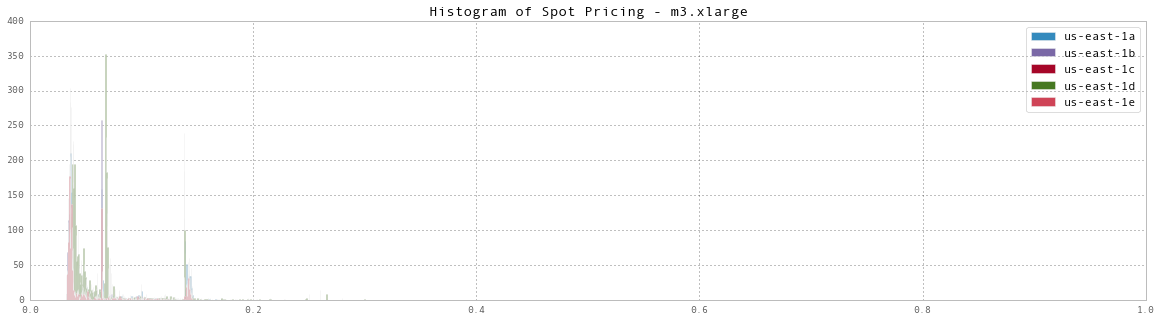

In [10]:
for k, g in df.sort(ascending=True).groupby(['InstanceType'], as_index=False):
    plt.figure(1, figsize(20,5))
    for key, grp in g.groupby(['AvailabilityZone'], as_index=False):
        plt.hist(grp['SpotPrice'], bins=1000, label=key)
        plt.xlim([0, 1])
        #grp.groupby(grp.index.dayofweek).agg(['mean']).plot()
    plt.legend()
    plt.title('Histogram of Spot Pricing - ' + k)
    plt.show()


Second step is to simply plot the results.  Like the histograms, let's separate the instance types and show spot price (y axis) as a function of time (x-axis).  The different colors represent different availability zones.

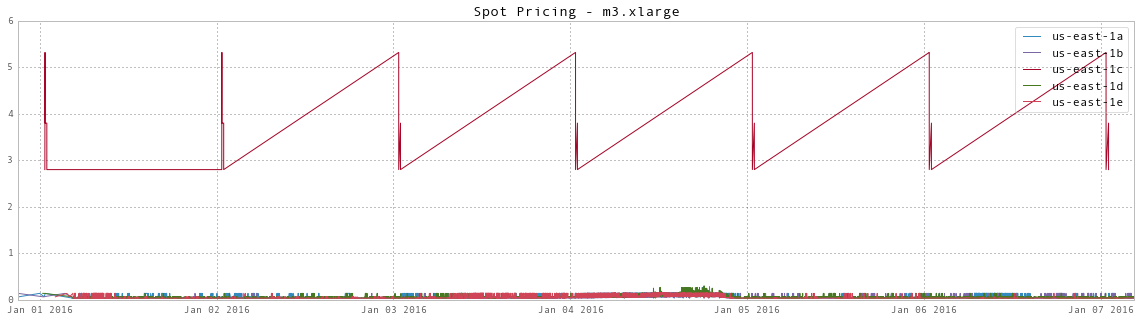

In [11]:
for k, g in df.sort(ascending=True).groupby(['InstanceType'], as_index=False):
    plt.figure(1, figsize(20,5))
    for key, grp in g.groupby(['AvailabilityZone'], as_index=False):
        plt.plot(grp.index, grp['SpotPrice'], label=key)
        #grp.groupby(grp.index.dayofweek).agg(['mean']).plot()
        
    plt.legend()
    plt.title('Spot Pricing - ' + k)
    plt.show()